30 30


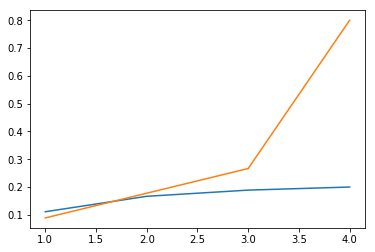

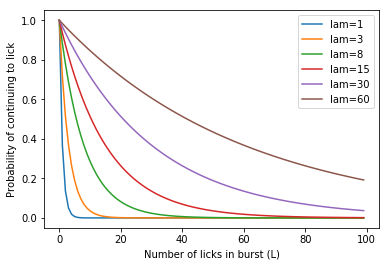

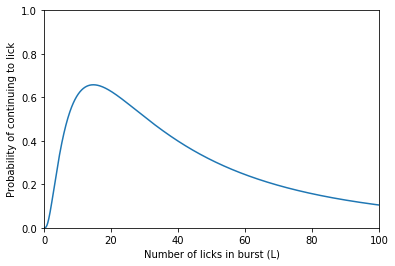

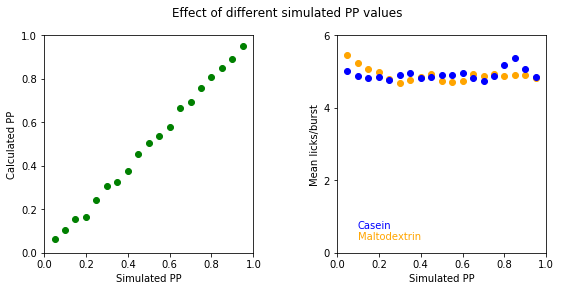

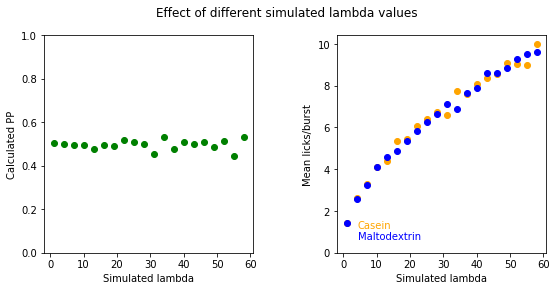

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'

%matplotlib inline
%run helperfx
%run lickmodel.ipynb

In [2]:
medfolder = 'C:\\Users\\James Rig\\Documents\\GitHub\\lickmodel\\data\\MED-PC datafile\\'
filename = medfolder+'!2019-02-25_10h53m.Subject IPP3.12'


CasVar = 'b'
MaltoVar = 'e'
caslicks, maltlicks = medfilereader(filename, varsToExtract=[CasVar, MaltoVar], remove_var_header=True)

In [3]:
# Make histogram data
bins = np.arange(0,3660,60)
cas_binned = np.histogram(caslicks, bins=bins)
malt_binned = np.histogram(maltlicks, bins=bins)

# Calculate smoothed protein preference
PP_binned = [c/(c+m) for c, m in zip(cas_binned[0], malt_binned[0])]
PP_binned = [0.5 if np.isnan(val) else val for val in PP_binned]
PP_binned_smooth = smooth2(PP_binned, 10)

# Prepare ILI data for lick distribution figures
all_licks = np.sort(caslicks+maltlicks)
ILIs = np.diff(all_licks)
bins = np.arange(0, 1, 0.02)
ILI_hist = np.histogram(ILIs, bins) 

# Plot session figure

def licks_over_timeFig(ax):
    y1 = np.ones(len(caslicks))
    y0 = np.zeros(len(maltlicks))

    ax.plot(caslicks,y1, 'o', color='blue')
    ax.plot(maltlicks,y0, 'o', color='orange')
    ax.plot(cas_binned[1][:-1], PP_binned_smooth, color='red')

    ax.set_ylabel('Protein preference')
    ax.set_xlabel('Time (min)')

    xticks=[0, 600, 1200, 1800, 2400, 3000, 3600]
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(int(t/60)) for t in xticks])

    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['Malto', 0.5, 'Casein'], ha='right')

def lickhistogram(ax, style='linear', texton=False):
    
    ax.plot(ILI_hist[1][:-1],ILI_hist[0])
    
    if texton:
        medianfreq = 'Median={:.2f} Hz'.format(1/np.median(ILIs))
        ax.text(0.95, 0.95, medianfreq,
                transform=ax.transAxes, ha='right', va='top')
    
    ax.set_yscale(style)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('ILI (s)')
    
def lickboxplot(ax, style='linear'):
    
    ax.boxplot(ILIs)
    ax.set_yscale(style)
    
    ax.set_ylabel('ILI (s)')
    ax.set_xticks([])

def example_dataFig(title='', savefig=False):
    f = plt.figure(figsize=(12,9))
    f.suptitle(title)
    gs = gridspec.GridSpec(2, 4, wspace=0.7, hspace=0.3, width_ratios=[1, 0.6, 1, 0.6])
    
    ax1 = f.add_subplot(gs[0, :])
    licks_over_timeFig(ax1)
    
    ax2 = f.add_subplot(gs[1, 0])
    lickhistogram(ax2, texton=True)
    
    ax3 = f.add_subplot(gs[1, 1])
    lickboxplot(ax3)
    
    ax4 = f.add_subplot(gs[1, 2])
    lickhistogram(ax4, style='log')

    ax5 = f.add_subplot(gs[1, 3])
    lickboxplot(ax5, style='log')
    
    if savefig:
        f.savefig(savefolder+'example_data.png')

C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys


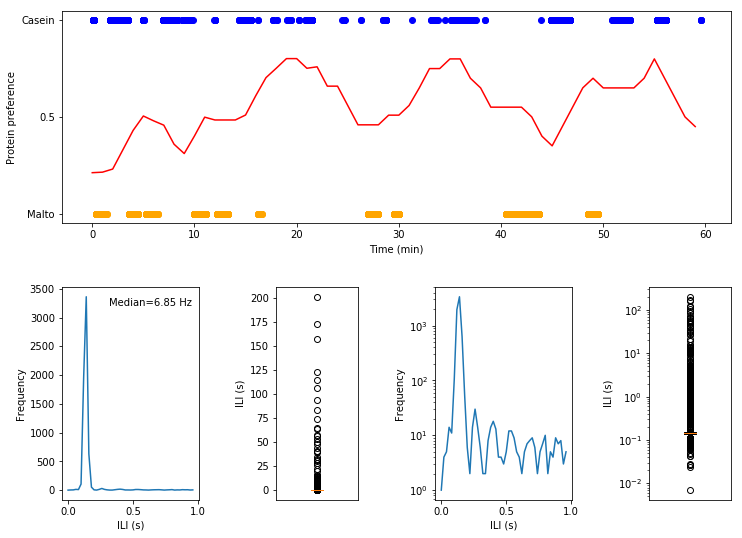

In [4]:
example_dataFig(savefig=True)

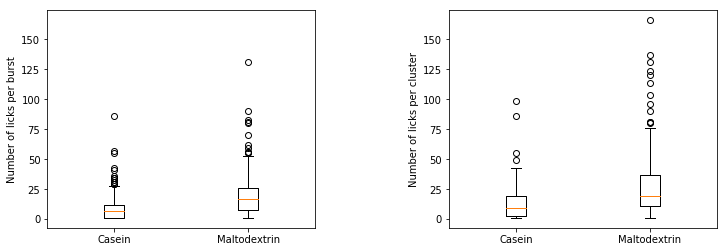

In [8]:
casBursts = lickCalc(caslicks, burstThreshold = 0.25)
casClusters = lickCalc(caslicks, burstThreshold = 0.5)

maltBursts = lickCalc(maltlicks, burstThreshold = 0.25)
maltClusters = lickCalc(maltlicks, burstThreshold = 0.5)

f = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, wspace=0.5)

ax1 = f.add_subplot(gs[0])
ax1.boxplot([casBursts['bLicks'], maltBursts['bLicks']])

ax1.set_xticklabels(['Casein', 'Maltodextrin'])
ax1.set_ylabel('Number of licks per burst')

ax2 = f.add_subplot(gs[1], sharey=ax1)
ax2.boxplot([casClusters['bLicks'], maltClusters['bLicks']])

ax2.set_xticklabels(['Casein', 'Maltodextrin'])
ax2.set_ylabel('Number of licks per cluster')

f.savefig(savefolder+'burstandclusters.png')

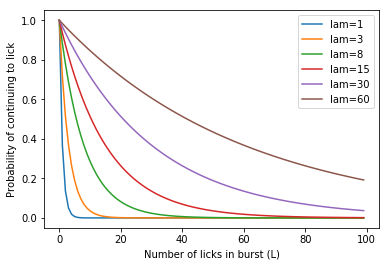

In [33]:
f, ax = plt.subplots()

lick_array = np.arange(0,100)
lam_array = [1, 3, 8, 15, 30, 60]
output_array = []

for lam in lam_array:
    output_array.append([math.exp(-x*(1/lam)) for x in lick_array])

for lam, y in zip(lam_array, output_array):
    ax.plot(lick_array, y)

ax.set_ylabel('Probability of continuing to lick')
ax.set_xlabel('Number of licks in burst (L)')
    
legend_array = ['lam='+str(lam) for lam in lam_array]
ax.legend(legend_array)

#f.savefig(savefolder+'exponential_decay.png')

Simulating data with values: PP=0.5 and lamda=15
0.5156174915905815
Simulating data with values: PP=0.85 and lamda=15
0.847972972972973
Simulating data with values: PP=0.5 and lamda=3
0.5036054225555235
Simulating data with values: PP=0.5 and lamda=60
0.4932715640855945


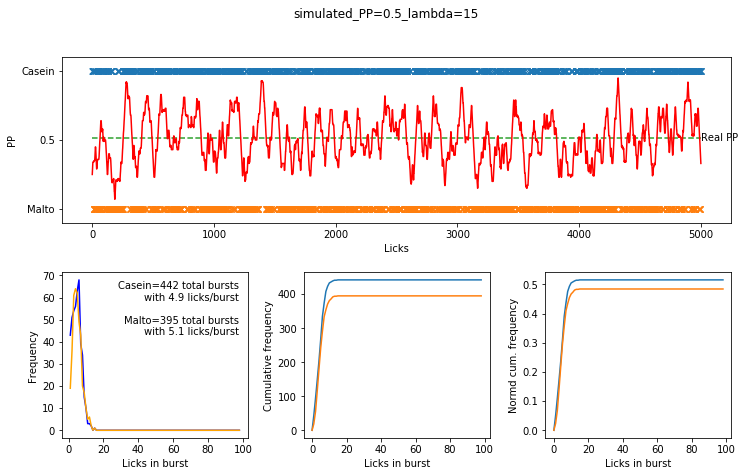

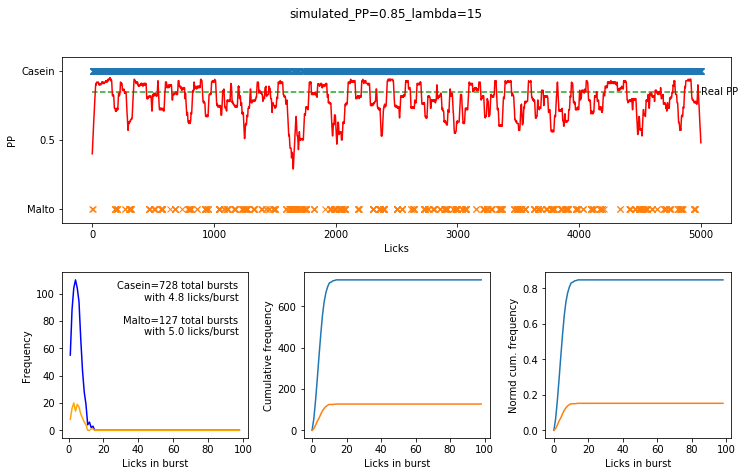

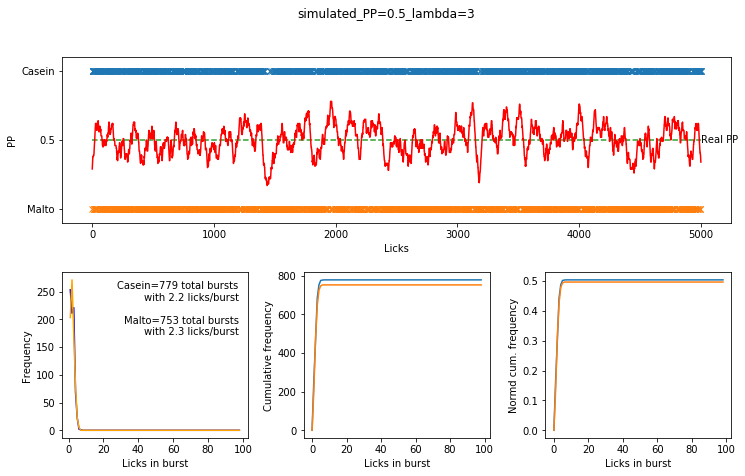

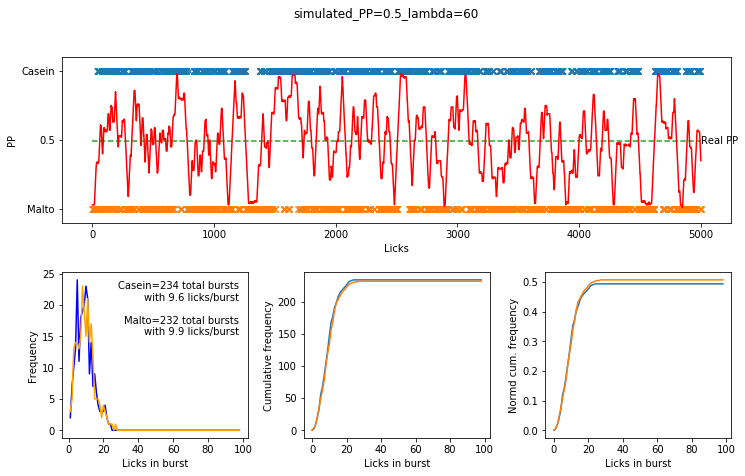

In [34]:
nruns=5000
histbins = np.arange(0,100)


def simulate_and_plot(PP, lam):
    print('Simulating data with values: PP={0} and lamda={1}'.format(PP,lam))
    ratkey = 'simulated_PP={0}_lambda={1}'.format(PP,lam)
    licks = runmodel(PP, lam, nruns)
    lickdata = analyse_licks(licks, histbins)
    print(lickdata['realPP'])
    makeSessionFig(lickdata, savefig=True, savefolder=savefolder, ratkey=ratkey)
    
simulate_and_plot(0.5, 15)
simulate_and_plot(0.85, 15)
simulate_and_plot(0.5, 3)
simulate_and_plot(0.5, 60)

In [13]:
len(licks)

5000

In [130]:
# For fitting simulated data - need to set boundbins above
histbins = np.arange(0,100)

# For simulating data
PP = 0.5
lam = 15
licks = runmodel(PP, lam, 5000)

# To analyse licks and fit data
lickdata = analyse_licks(licks, histbins)

bounds = {'PP':[0.05, 1, 0.05], 'lam':[1, 60, 3]}

boundbins = []
boundbins.append(np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][2]))
boundbins.append(np.arange(bounds['lam'][0], bounds['lam'][1], bounds['lam'][2]))

nruns=len(lickdata['licks'])

fitted = fit(lickdata, boundbins, histbins, nruns=nruns, fittype='cumsums')

gridscores = fitted['grid']

pp_vals = ["{:.1f}".format(x+0.05) for x in boundbins[0]][0::2]
lam_vals = ["{:.0f}".format(x) for x in boundbins[1]][0::2]

Fitting data using bounds provided.


In [131]:
def fitted_heatmap(fitted, ax, plotML=True, simvals=[]):
    sns.set()
    sns.heatmap(np.log(fitted['grid']), cbar=False, ax=ax)
    
    if plotML:
        A = fitted['pp_marglik']
        y = np.where(A == np.amax(A))[0]+0.5
        ax.plot([0,20], [y, y], color='w')
        
        B = fitted['lam_marglik']
        x = np.where(B == np.amax(B))[0]+0.5
        ax.plot([x, x], [0,20], color='w')
        
    if len(simvals) == 2:
        x = np.where(simvals[1] == boundbins[1])[0] #need to be able to index for vals not included as boundbins
        y = np.where(simvals[0] == boundbins[0])[0]
        ax.plot(x, y+0.5, '+', color='black')
    
    ax.set_ylim([0, 19])
    ax.set_yticks(np.arange(0.5, 19, 2))
    ax.set_yticklabels(pp_vals, rotation=0)

    ax.set_xticks(np.arange(0.5, 21, 2))
    ax.set_xticklabels(lam_vals)

    ax.set_xlabel('lambda')
    ax.set_ylabel('PP')
    
    mpl.rcParams.update(my_params)

def ML_PP(fitted, ax):
    
    ax.plot(fitted['pp_marglik'], np.arange(0.5,19.5,1))
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([])
    
def ML_lam(fitted, ax):
    
    ax.plot(np.arange(0.5,20.5,1),fitted['lam_marglik'])
    ax.set_xlabel('lambda')
    ax.set_yticks([])

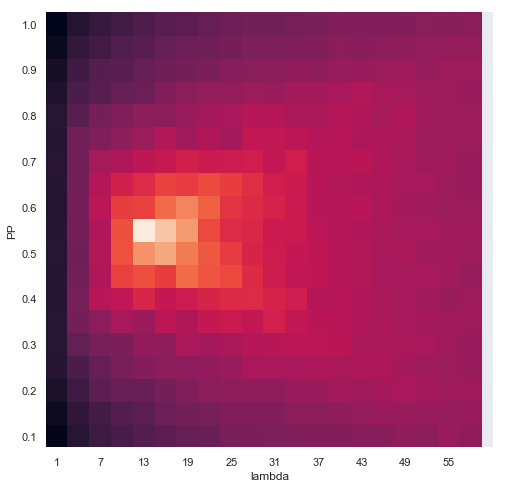

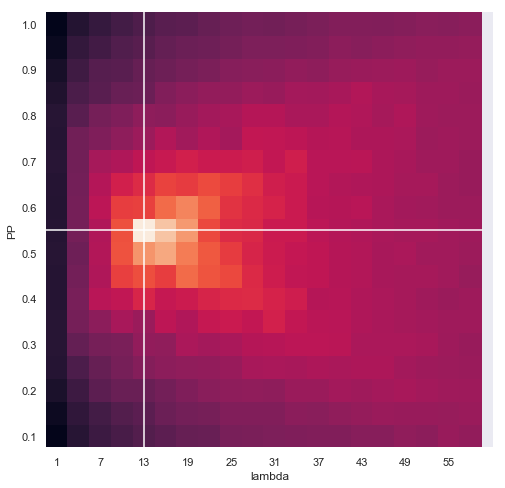

In [136]:
f, ax = plt.subplots(figsize=(8,8))
fitted_heatmap(fitted, ax, plotML=False)

f.savefig(savefolder+'fitteddata_withoutML.png')

f, ax = plt.subplots(figsize=(8,8))
fitted_heatmap(fitted, ax, plotML=True)

f.savefig(savefolder+'fitteddata_with_ML.png')

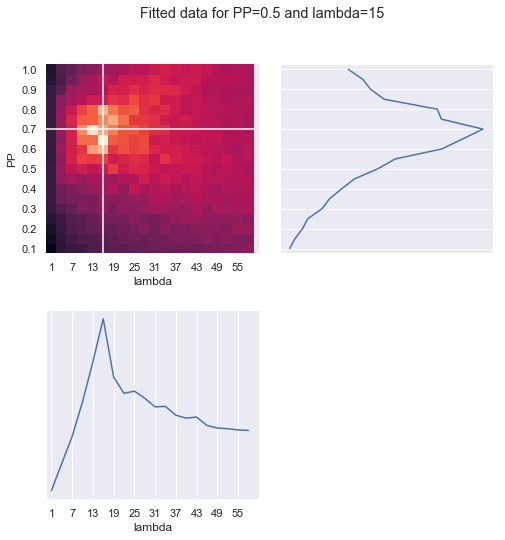

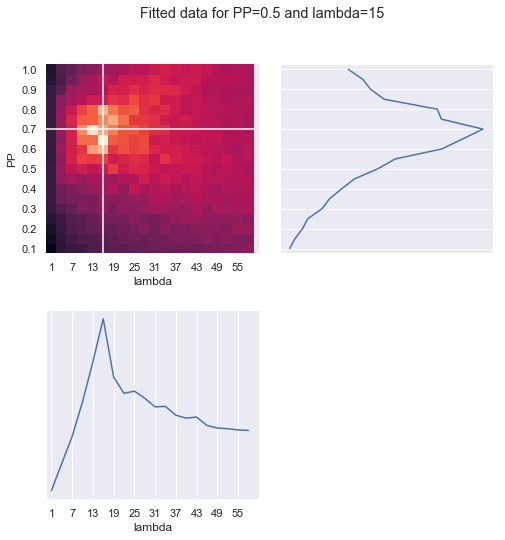

In [141]:
# Plots grid search plus max likelihood graphs    
def fit_plus_MLs(fitted, savefig=False):
    f = plt.figure(figsize=(8, 8))
    f.suptitle('Fitted data for PP={0} and lambda={1}'.format(PP, lam))
    gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.1)

    ax1 = f.add_subplot(gs[0, 0])
    fitted_heatmap(fitted, ax1)

    ax2 = f.add_subplot(gs[0,1], sharey=ax1)
    ML_PP(fitted, ax2)

    ax3 = f.add_subplot(gs[1,0], sharex=ax1)
    ML_lam(fitted, ax3)

# print('Estimated PP=', fitted['pp_EV'], ' and estimated lambda=', fitted['lam_EV'], ' using EV')
# print('Estimated PP=', fitted['pp_ML'], ' and estimated lambda=', fitted['lam_ML'], ' using ML')
    if savefig:
        f.savefig(savefolder+'fitted_simdata.png')
    
    return f
        
fit_plus_MLs(fitted)

Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.


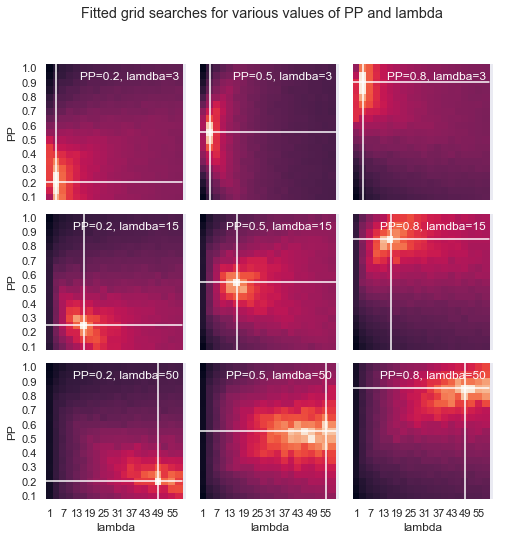

In [129]:
# to do grid search for variopus simulated parameters

# stable parameters
nruns = 5000
bounds = {'PP':[0.05, 1, 0.05], 'lam':[1, 60, 3]}

boundbins = []
boundbins.append(np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][2]))
boundbins.append(np.arange(bounds['lam'][0], bounds['lam'][1], bounds['lam'][2]))

pp_vals = ["{:.1f}".format(x+0.05) for x in boundbins[0]][0::2]
lam_vals = ["{:.0f}".format(x) for x in boundbins[1]][0::2]

# Arrays to cycle through
PP_array = [0.2, 0.5, 0.8]
lam_array = [3, 15, 50]

# Sets up figure

f = plt.figure(figsize=(8, 8))
f.suptitle('Fitted grid searches for various values of PP and lambda')
gs = gridspec.GridSpec(3, 3, hspace=0.1, wspace=0.1)

for ix, PP in enumerate(PP_array):
    for iy, lam in enumerate(lam_array):
        
        licks = runmodel(PP, lam, nruns)
        lickdata = analyse_licks(licks, histbins)
        fitted = fit(lickdata, boundbins, histbins, nruns=nruns, fittype='cumsums')
        
        ax = f.add_subplot(gs[iy, ix])
        fitted_heatmap(fitted, ax)
        textstr = 'PP={0}, lamdba={1}'.format(PP, lam)
        ax.text(0.95, 0.95, textstr, color='white',
                transform=ax.transAxes, ha='right', va='top')

all_axes = f.get_axes()
for axis in all_axes:
    if not axis.is_first_col():
        axis.set_yticks([])
        axis.set_ylabel('')
        
    if not axis.is_last_row():
        axis.set_xticks([])
        axis.set_xlabel('')

f.savefig(savefolder+'multiple_simulations.png')

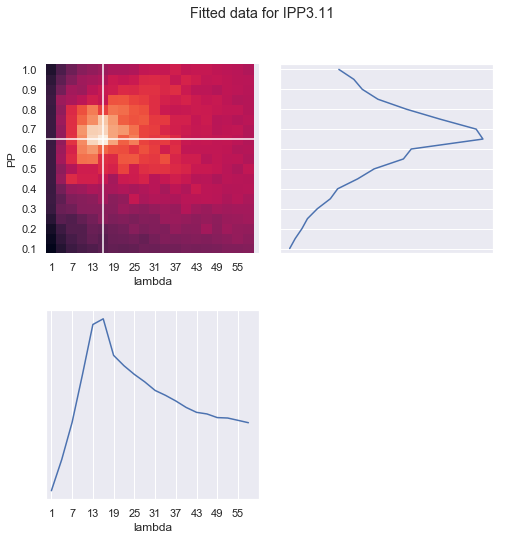

In [144]:
# To make fitted figures for real data

def fit_plus_MLs(fitted, subject='blank', savefig=False):
    f = plt.figure(figsize=(8, 8))
    f.suptitle('Fitted data for '+ratkey)
    gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.1)

    ax1 = f.add_subplot(gs[0, 0])
    fitted_heatmap(fitted, ax1)

    ax2 = f.add_subplot(gs[0,1], sharey=ax1)
    ML_PP(fitted, ax2)

    ax3 = f.add_subplot(gs[1,0], sharex=ax1)
    ML_lam(fitted, ax3)

# print('Estimated PP=', fitted['pp_EV'], ' and estimated lambda=', fitted['lam_EV'], ' using EV')
# print('Estimated PP=', fitted['pp_ML'], ' and estimated lambda=', fitted['lam_ML'], ' using ML')
    if savefig:
        f.savefig(savefolder+ratkey+'_fitted.png')
    
    return f

<Figure size 432x288 with 0 Axes>

Extracted licks from Med data
PR dict_keys(['IPP3.3', 'IPP3.4', 'IPP3.7', 'IPP3.8', 'IPP3.11', 'IPP3.12'])
NR dict_keys(['IPP3.1', 'IPP3.2', 'IPP3.5', 'IPP3.6', 'IPP3.9', 'IPP3.10'])
Fitting data using bounds provided.


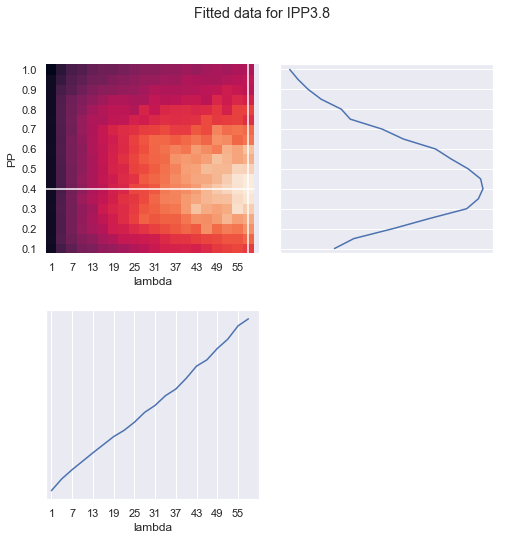

In [149]:
# Running real rats to fit to model

# for extracting real data
%run extractlicks.ipynb

print('PR', test1_data_PR.keys())
print('NR', test1_data_NR.keys())

ratkey = 'IPP3.8'
licks = test1_data_PR[ratkey]
lickdata = analyse_licks(licks, histbins)
nruns = len(lickdata['licks'])

bounds = {'PP':[0.05, 1, 0.05], 'lam':[1, 60, 3]}

boundbins = []
boundbins.append(np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][2]))
boundbins.append(np.arange(bounds['lam'][0], bounds['lam'][1], bounds['lam'][2]))

pp_vals = ["{:.1f}".format(x+0.05) for x in boundbins[0]][0::2]
lam_vals = ["{:.0f}".format(x) for x in boundbins[1]][0::2]

fitted = fit(lickdata, boundbins, histbins, nruns=nruns, fittype='cumsums')
f = fit_plus_MLs(fitted, subject=ratkey, savefig=True)




<Figure size 432x288 with 0 Axes>

Extracted licks from Med data
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.


C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars


Fitting data using bounds provided.
Fitting data using bounds provided.


C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in longlong_scalars


Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.
Fitting data using bounds provided.


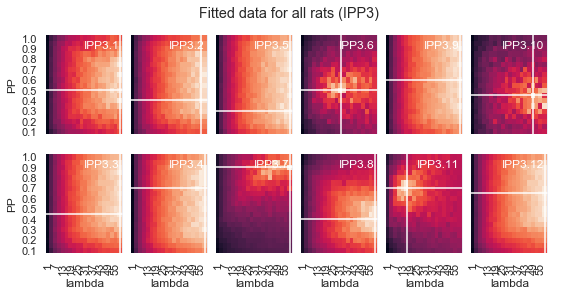

In [152]:
# To make grid searches for all rats using current parameters

%run extractlicks.ipynb




bounds = {'PP':[0.05, 1, 0.05], 'lam':[1, 60, 3]}

boundbins = []
boundbins.append(np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][2]))
boundbins.append(np.arange(bounds['lam'][0], bounds['lam'][1], bounds['lam'][2]))

pp_vals = ["{:.1f}".format(x+0.05) for x in boundbins[0]][0::2]
lam_vals = ["{:.0f}".format(x) for x in boundbins[1]][0::2]

f = plt.figure(figsize=(9, 4))
f.suptitle('Fitted data for all rats (IPP3)')
gs = gridspec.GridSpec(2, 6, hspace=0.2, wspace=0.1)

for ix, ratkey in enumerate(test1_data_NR.keys()):
    licks = test1_data_NR[ratkey]
    lickdata = analyse_licks(licks, histbins)
    nruns = len(lickdata['licks'])

    fitted = fit(lickdata, boundbins, histbins, nruns=nruns, fittype='cumsums')
    
    ax = f.add_subplot(gs[0, ix])
    fitted_heatmap(fitted, ax)
    ax.text(0.95, 0.95, ratkey, color='white',
            transform=ax.transAxes, ha='right', va='top')
    
for ix, ratkey in enumerate(test1_data_PR.keys()):
    licks = test1_data_PR[ratkey]
    lickdata = analyse_licks(licks, histbins)
    nruns = len(lickdata['licks'])

    fitted = fit(lickdata, boundbins, histbins, nruns=nruns, fittype='cumsums')
    
    ax = f.add_subplot(gs[1, ix])
    fitted_heatmap(fitted, ax)
    ax.text(0.95, 0.95, ratkey, color='white',
            transform=ax.transAxes, ha='right', va='top')
        
all_axes = f.get_axes()
for axis in all_axes:
    if not axis.is_first_col():
        axis.set_yticks([])
        axis.set_ylabel('')
        
    if not axis.is_last_row():
        axis.set_xticks([])
        axis.set_xlabel('')

f.savefig(savefolder+'all_IPP3_rats.png')


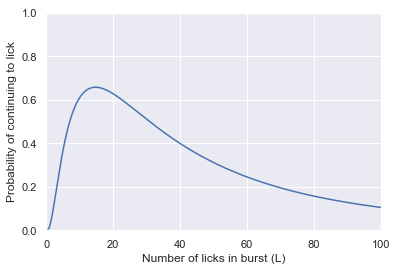

In [155]:
# To plot log-normal distribution
f, ax = plt.subplots()

x_array = np.linspace(0, 100, 1000)

alpha = 40
s=1
dist = lognorm(s, loc=0)

y = [dist.pdf(x/alpha+0)+0 for x in x_array]

ax.plot(x_array,y)
ax.set_xlim([0,100])
ax.set_ylim([0, 1])

ax.set_ylabel('Probability of continuing to lick')
ax.set_xlabel('Number of licks in burst (L)')

f.savefig(savefolder+'lognormal.png')

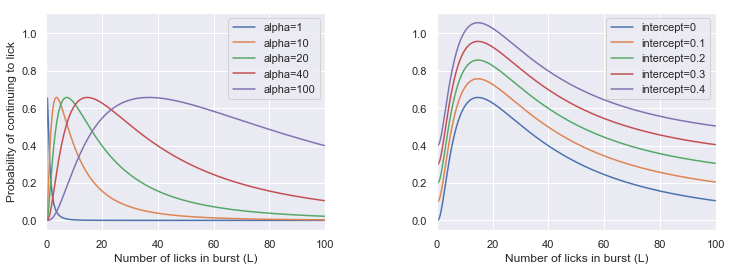

In [170]:
f = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, wspace=0.4)

x_array = np.linspace(0, 100, 1000)

alpha_array = [1, 10, 20, 40, 100]
intercept = 0
ax1 = f.add_subplot(gs[0,0])
for alpha in alpha_array:
    y = [dist.pdf(x/alpha)+0 for x in x_array]
    ax1.plot(x_array,y)
    ax1.set_ylabel('Probability of continuing to lick')
    
legend_array = ['alpha='+str(alpha) for alpha in alpha_array]
ax1.legend(legend_array)

alpha = 40
intercept_array = [0, 0.1, 0.2, 0.3, 0.4]
ax2 = f.add_subplot(gs[0,1], sharey=ax1)
for i in intercept_array:
    y = [dist.pdf(x/alpha)+i for x in x_array]
    ax2.plot(x_array,y)
    
legend_array = ['intercept='+str(i) for i in intercept_array]
ax2.legend(legend_array)
    
for axis in [ax1, ax2]:
    axis.set_xlim([0,100])
    axis.set_xlabel('Number of licks in burst (L)')

# alpha = 40
# i = 0
# beta_array = [0, 0.1, 0.2, 0.3, 0.8, -1]
# ax3 = f.add_subplot(gs[0,2])
# for beta in beta_array:
#     y = [dist.pdf(x/alpha+beta)+i for x in x_array]
#     ax3.plot(x_array,y)

f.savefig(savefolder+'lognormal_different_vals.png')